# Imports and configuring a reproducibility seed

In [1]:
import os
import numpy as np
import random
import tensorflow as tf

seed = 1729959202

np.random.seed(seed)

random.seed(seed)

tf.random.set_seed(seed)

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

2024-10-27 01:11:03.138271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729984263.147107   11011 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729984263.149879   11011 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 01:11:03.159814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read data from I/O

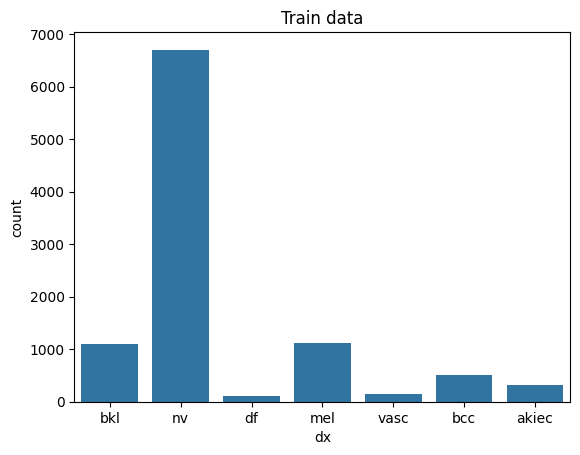

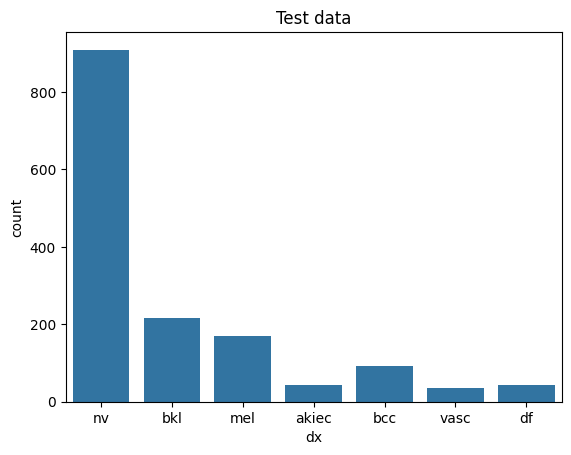

In [2]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  
test_image_dir = 'data/ham10000/images/test_images/'

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.title('Train data')
plt.show()

test_data_path = 'data/ham10000/images/ISIC2018_Task3_Test_GroundTruth.csv'

test_df = pd.read_csv(test_data_path)
test_df['image_path'] = test_image_dir + test_df['image_id'] + '.jpg'
test_df['label'] = label_encoder.transform(test_df['dx'])

sns.countplot(x='dx', data=test_df)
plt.title('Test data')
plt.show()

train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# Check for data leaks

In [3]:
train_set = set(train_df['image_path'])
val_set = set(val_df['image_path'])
test_set = set(test_df['image_path'])

print("Overlaps between train and validation:", train_set.intersection(val_set))
print("Overlaps between train and test:", train_set.intersection(test_set))
print("Overlaps between validation and test:", val_set.intersection(test_set))

Overlaps between train and validation: set()
Overlaps between train and test: set()
Overlaps between validation and test: set()


# Convert label to string for API compatibility

In [4]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Load and Augment Images and create tf.Data.Dataset instances for all parts of the data

In [5]:
image_size = (128, 128)
batch_size = 128
num_classes = len(df['dx'].unique())
img_height, img_width = image_size

def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0  

    if augment:
        img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))  
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)

    return img, label

def create_dataset(df, augment=False, batch_size=32):
    df = df[df['image_path'].apply(os.path.exists)]
    
    image_paths = df['image_path'].values
    labels = df['label'].values
    labels = tf.keras.utils.to_categorical(labels, num_classes)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def preprocess_with_augment(image_path, label):
        return load_and_preprocess_image(image_path, label, augment)

    dataset = dataset.map(preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

train_dataset = create_dataset(train_df, augment=True, batch_size=batch_size)
val_dataset = create_dataset(val_df, batch_size=batch_size)
test_dataset = create_dataset(test_df, batch_size=batch_size)


I0000 00:00:1729984270.366969   11011 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


# Show an image of each class

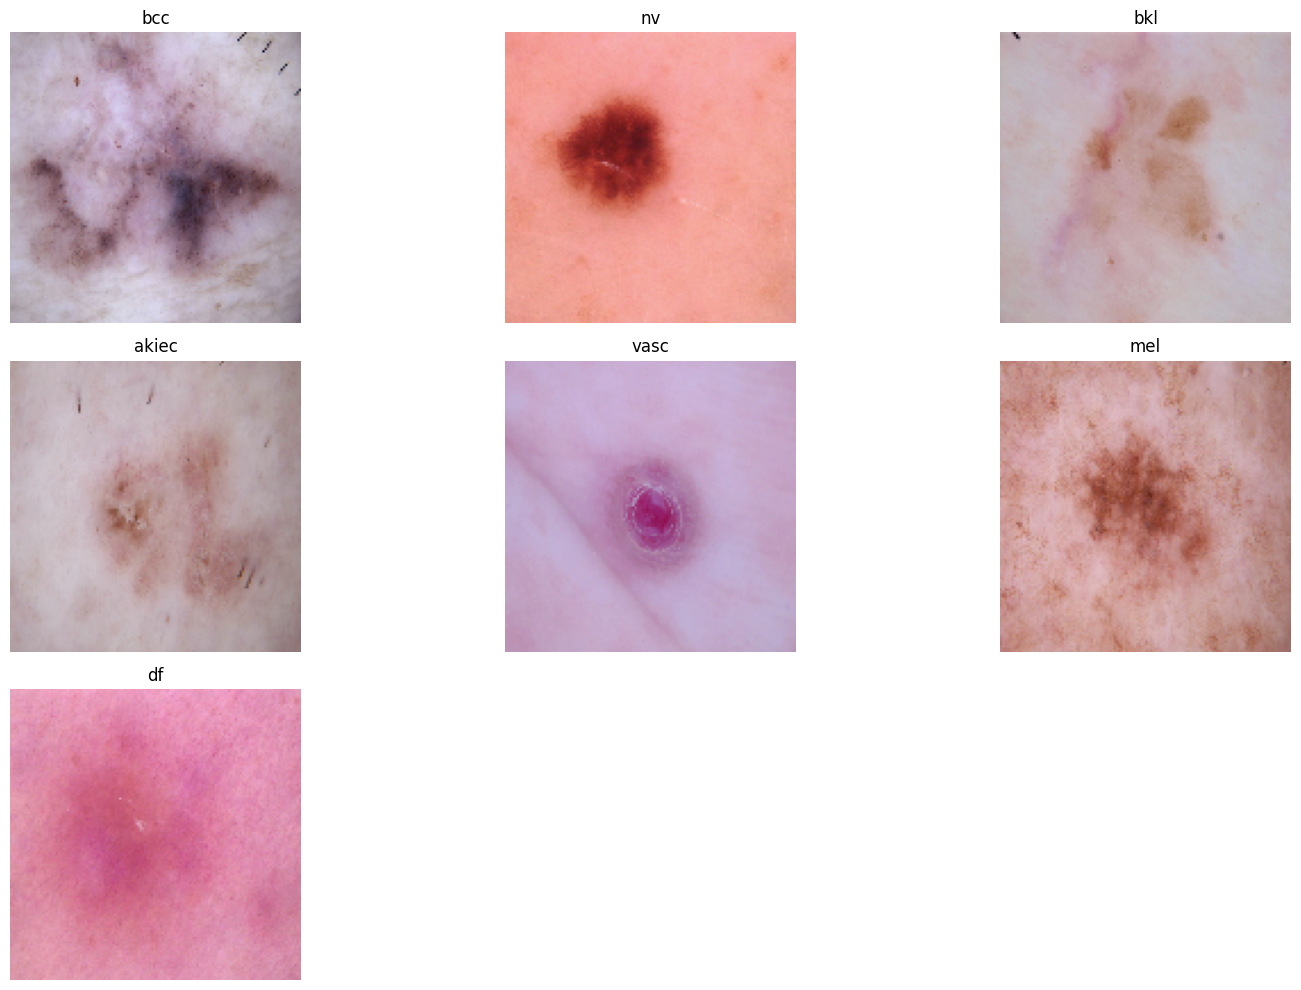

In [6]:
from tensorflow.keras.preprocessing.image import load_img

unique_classes = train_df['label'].unique()

plt.figure(figsize=(15, 10))

for i, label in enumerate(unique_classes):
    image_path = train_df[train_df['label'] == label]['image_path'].values[0]
    
    img = load_img(image_path, target_size=image_size)
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label_encoder.inverse_transform([int(label)])[0])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Verify dataset counts

In [7]:
def check_dataset_shapes(dataset, name):
    print(f"Checking {name} dataset:")
    total_images = 0
    for batch in dataset:
        images, labels = batch
        total_images += images.shape[0]
    print(f"Total number of images in {name} dataset: {total_images}\n")

check_dataset_shapes(train_dataset, "train")
check_dataset_shapes(val_dataset, "val")
check_dataset_shapes(test_dataset, "test")

Checking train dataset:


2024-10-27 01:03:27.625543: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total number of images in train dataset: 9013

Checking val dataset:


2024-10-27 01:03:27.961263: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total number of images in val dataset: 1002

Checking test dataset:
Total number of images in test dataset: 1511



# Verify that no image data has been lost in preprocessing

Visualizing images from train dataset:


2024-10-27 01:03:28.589012: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


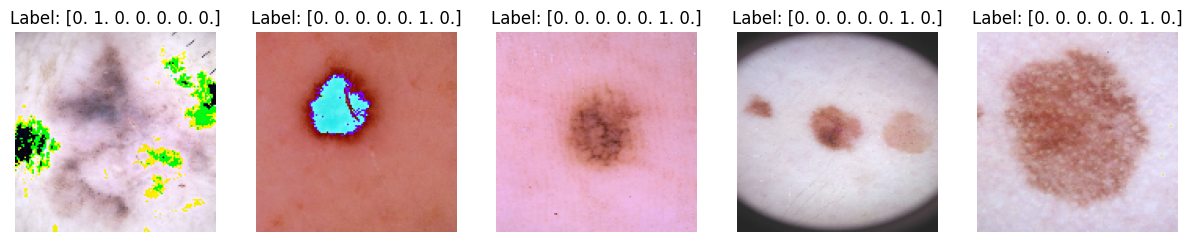

Visualizing images from val dataset:


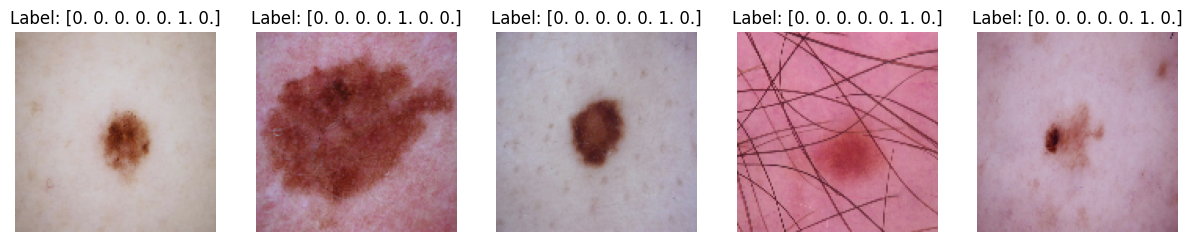

Visualizing images from test dataset:


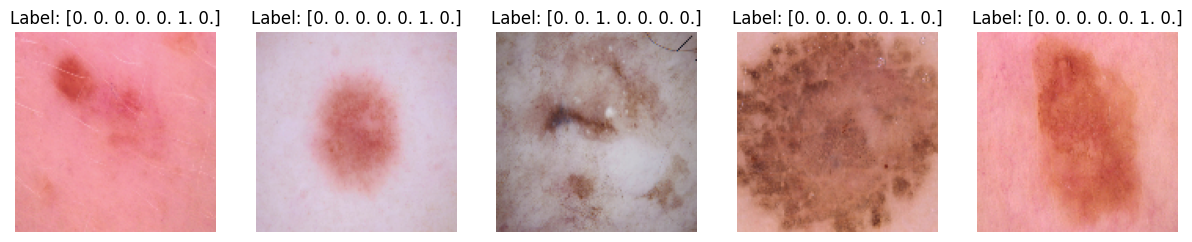

In [8]:
import matplotlib.pyplot as plt

def visualize_images(dataset, name, num_images=5):
    print(f"Visualizing images from {name} dataset:")
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):  
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            img = (images[i].numpy() * 255).astype("uint8")
            plt.imshow(img)
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.show()

visualize_images(train_dataset, "train")
visualize_images(val_dataset, "val")
visualize_images(test_dataset, "test")

# Model initialization

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
def create_cnn_model(input_shape=(128, 128, 3), num_classes=7):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

input_shape = (img_height, img_width, 3)
num_classes = len(df['label'].unique()) 
model = create_cnn_model(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'],
              )

model.summary()


/home/bosa/manu2/manu/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 899,687 (3.43 MB)

 Trainable params: 899,687 (3.43 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    )

Epoch 1/20


I0000 00:00:1729983870.424925    8536 service.cc:148] XLA service 0x7f8b24004ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729983870.424944    8536 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-10-27 01:04:30.461759: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729983870.665547    8536 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-10-27 01:04:31.015556: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1000', 12 bytes spill stores, 16 bytes spill loads

I0000 00:00:1729983879.155503    8536 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 25s 211ms/step - accuracy: 0.6194 - loss: 1.2430 - val_accuracy: 0.6697 - val_loss: 0.9842
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6686 - loss: 1.0173 - val_accuracy: 0.6707 - val_loss: 0.9577
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6699 - loss: 0.9497 - val_accuracy: 0.6677 - val_loss: 0.9625
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6709 - loss: 0.9375 - val_accuracy: 0.6756 - val_loss: 0.8868
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6785 - loss: 0.8910 - val_accuracy: 0.6747 - val_loss: 0.8965
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6831 - loss: 0.8868 - val_accuracy: 0.6727 - val_loss: 0.8945
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.6829 - loss: 0.8710 - val_accuracy: 0.6796 - val_loss: 0.8434
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6864 - loss: 0.8501 - val_accuracy: 0.6776 - val_loss: 

# Baseline model evaluation, plotting ROC graphs and other metrics

In [12]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.6833 - loss: 0.8614
Test Accuracy: 0.6551952362060547


In [13]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

y_score = model.predict(test_dataset)

baseline_ovo_auc = roc_auc_score(y_true, y_score, multi_class="ovo")
baseline_ovr_auc = roc_auc_score(y_true, y_score, multi_class="ovr")

baseline_f1_score = f1_score(y_true.argmax(axis=1), y_score.argmax(axis=1), average="weighted")

print(f'Baseline model OVO AUC: {baseline_ovo_auc}')
print(f'Baseline model OVR AUC: {baseline_ovr_auc}')
print(f'Baseline model F1 Score: {baseline_f1_score}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Baseline model OVO AUC: 0.8707570046747423
Baseline model OVR AUC: 0.8707570046747423
Baseline model F1 Score: 0.5775492550117013


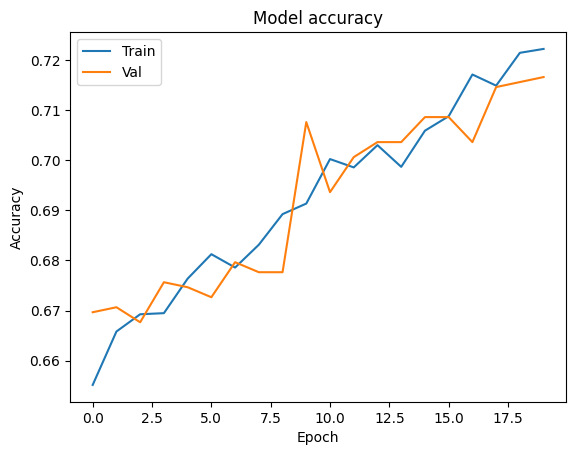

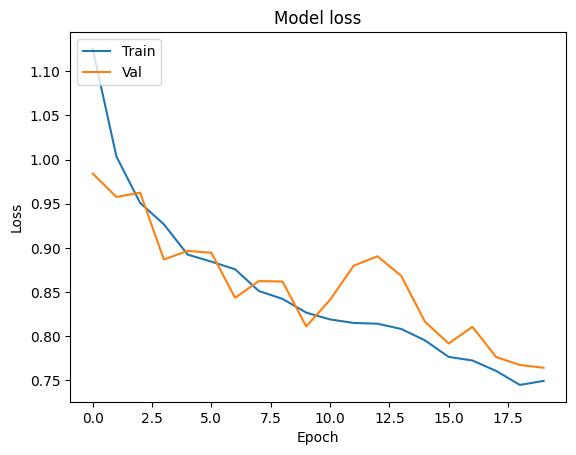

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

2024-10-27 01:06:39.068593: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


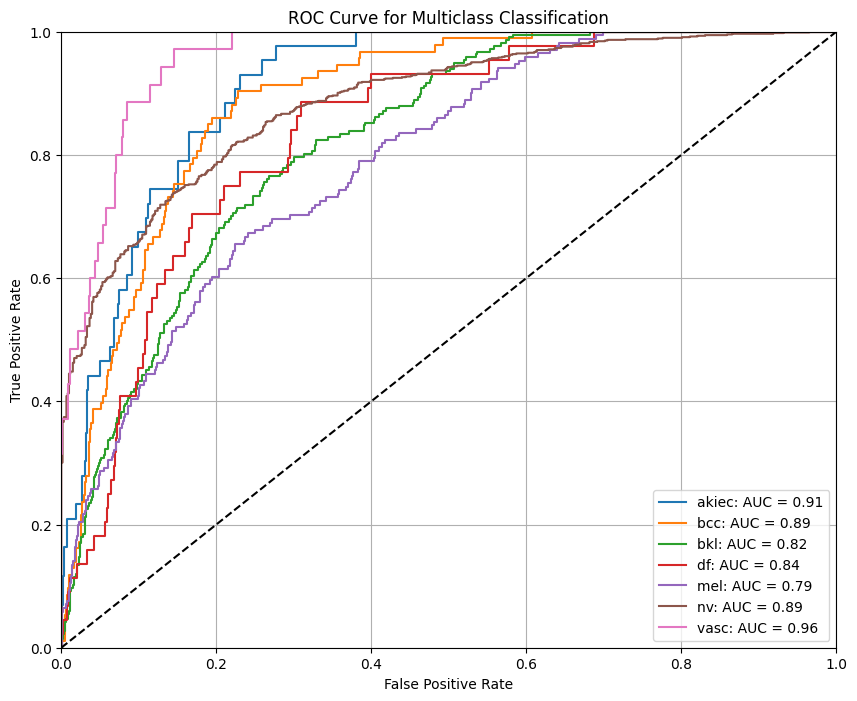

In [15]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_score = model.predict(test_dataset)

y_true = to_categorical(np.argmax(y_true, axis=1), num_classes)

class_names = label_encoder.inverse_transform(np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]}: AUC = {roc_auc[i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [16]:
import os

# Define the path where you want to save the model
save_dir = 'models/baseline/'
model_path = os.path.join(save_dir, 'baseline_model.keras')

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the model
model.save(model_path, overwrite=True, zipped=True)


# Trying out Bayesian optimization with Keras Tuner

In [6]:
from tensorflow.keras import backend as K
K.clear_session()


In [9]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout



def build_model(hp):
    # Define hyperparameters
    conv_1_filters = hp.Int('conv_1_filters', min_value=32, max_value=256, step=32)
    conv_2_filters = hp.Int('conv_2_filters', min_value=32, max_value=128, step=32)
    conv_3_filters = hp.Int('conv_3_filters', min_value=32, max_value=64, step=16)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])


    # Build the model
    model = Sequential()
    input_shape = (128, 128, 3)
    model.add(Input(input_shape))
    model.add(Conv2D(
        filters=conv_1_filters,
        kernel_size=(2,2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=conv_2_filters,
        kernel_size=(2,2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=conv_3_filters,
        kernel_size=(2,2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(
        units=dense_units,
        activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax')) 

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20, 
    directory='first_hyperparameter_search',
    project_name='cnn_bayesian_search',
    seed=seed)

In [ ]:
tuner.search(
    train_dataset,
    epochs=20,
    validation_data=val_dataset, )

Trial 2 Complete [00h 00m 13s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 32s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
160               |256               |conv_1_filters
64                |96                |conv_2_filters
48                |32                |conv_3_filters
64                |128               |dense_units
0.0025314         |0.0019884         |learning_rate
sigmoid           |relu              |activation

Epoch 1/20
